# Лабораторная работа 4. Цифровая обработка изображений.

В этой работе рассматриваются различные виды цифровой обработки изображений.

Цель лабораторной работы:
1. Бинаризация
2. Выделение границ
3. Методы анализа изображений
4. Локальные особенности. Особые точки.


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import sys
sys.path.append('../')
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from utility import util

# Изменим стандартный размер графиков matplotlib
plt.rcParams["figure.figsize"] = [6, 4]

## 1 Бинаризация

В обработке изображений часто используется процедура пороговой бинаризации -- разбиения изображения на две области, одна из которых содержит все пиксели со значением ниже некоторого порога, а другая содержи все пиксели со значением выше этого порога.
Оптимальная пороговая сегментация основана на приближении гистограммы изображения к некоторой кривой с использованием весовых сумм двух или более вероятностей интенсивности с нормальным распределением. Тогда порог - это набор ближайших уровней яркости, соответствующих минимуму вероятности между максимумами двух или более нормальных распределений.


<img src="../content/binarization_examle.png" width="800"/>

Примеры бинаризации изображений будем рассматривать на изображении хлорелл под микроскопом


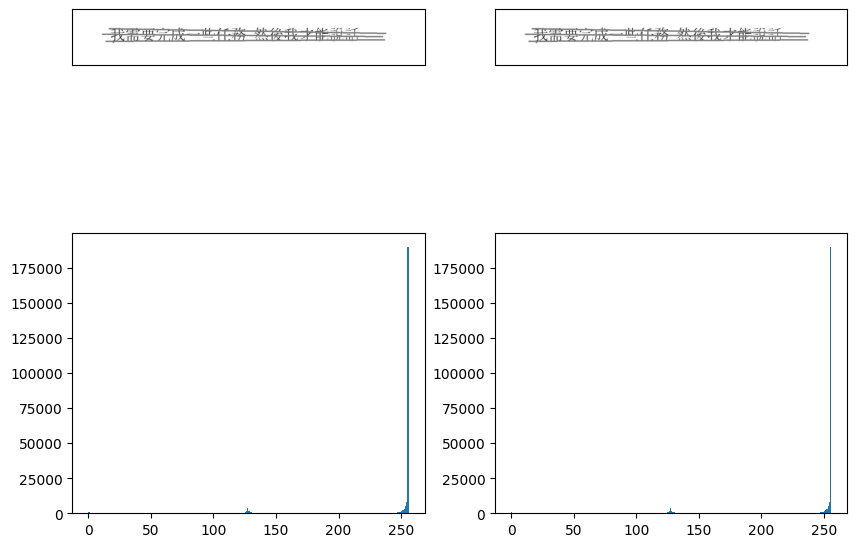

In [17]:
image1 = cv.imread('../images/lab4.png')
image2 = cv.imread('../images/lab4.png')
rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
hsv_image1 = cv.cvtColor(image1, cv.COLOR_BGR2HSV)
gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
rgb_image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)
hsv_image2 = cv.cvtColor(image2, cv.COLOR_BGR2HSV)
gray_image2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

channels = [0]
histSize = [256]
range = [0, 256]

gs = plt.GridSpec(2, 2)
plt.figure(figsize=(10, 8))
plt.subplot(gs[0])
plt.imshow(gray_image1, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.subplot(gs[1])
plt.imshow(gray_image2, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.subplot(gs[2])
plt.hist(gray_image1.reshape(-1), 256, range)
plt.subplot(gs[3])
plt.hist(gray_image2.reshape(-1), 256, range)
plt.show()




### 1.1 Бинаризация полутоновых изображений (пороговая фильтрация).

Рассмотрим простую бинаризацию на примере полутонового изображения.

Бинаризация полутоновых изображений осуществляется просто. Для каждого пикселя применяется одно и то же пороговое значение. Если значение пикселя меньше порогового значения, оно имеет значение 0, в противном случае — максимальное значение. В библиотеке OpenCV есть функция для бинаризации изображений cv.threshold(), для применения пороговых значений. Функция принимает несколько параметров:
- image -- изображение, к которому применяется бинаризация;
- threshold -- пороговое значение;
- maxval -- максимальное значение, которое присваивается значениям пикселей, превышающим пороговое значение;
- type -- тип порога.

OpenCV предоставляет различные типы пороговых значений:
- cv.THRESH_BINARY
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   maxval \; &\textit{if image(x, y) > threshold } \\
   0 \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$
- cv.THRESH_BINARY_INV
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   0 \; &\textit{if image(x, y) > threshold } \\
   maxval \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$
- cv.THRESH_TRUNC
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   threshold \; &\textit{if image(x, y) > threshold } \\
   image(x,y) \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$
- cv.THRESH_TOZERO
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   image(x, y) \; &\textit{if image(x, y) > threshold } \\
   0 \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$
- cv.THRESH_TOZERO_INV
$$
\begin{equation*}
out(x, y) =
 \begin{cases}
   0 \; &\textit{if image(x, y) > threshold } \\
   image(x, y) \; &\textit{иначе}
 \end{cases}
\end{equation*}
$$

Подробнее по типам смотри [документацию](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#gaa9e58d2860d4afa658ef70a9b1115576)



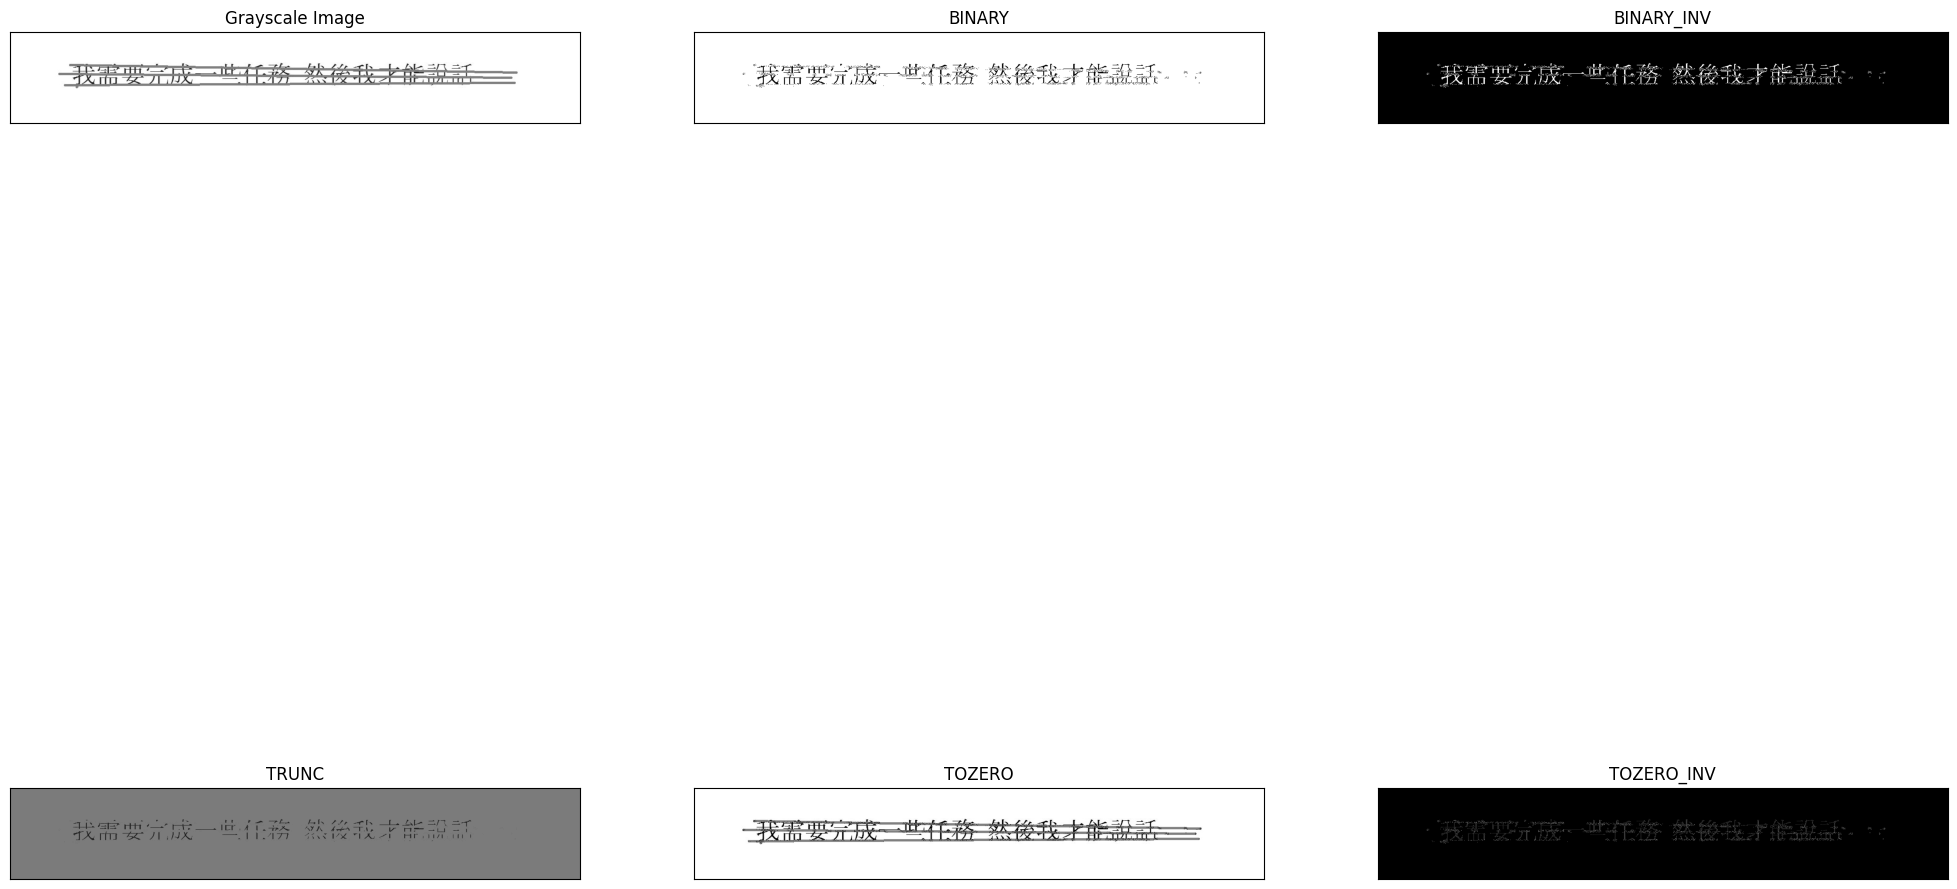

In [5]:
threshold = 123
image = gray_image1

ret, thresh1 = cv.threshold(image, threshold, 255, cv.THRESH_BINARY)
ret, thresh2 = cv.threshold(image, threshold, 255, cv.THRESH_BINARY_INV)
ret, thresh3 = cv.threshold(image, threshold, 255, cv.THRESH_TRUNC)
ret, thresh4 = cv.threshold(image, threshold, 255, cv.THRESH_TOZERO)
ret, thresh5 = cv.threshold(image, threshold, 255, cv.THRESH_TOZERO_INV)
titles = ['Grayscale Image', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']
images = [image, thresh1, thresh2, thresh3, thresh4, thresh5]
plt.figure(figsize=(25, 18))
for i in np.arange(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], 'gray', vmin=0, vmax=255)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### 1.2 Бинаризация Оцу (Otsu's Binarization)

Для определения оптимального порога бинаризации предложено большое количество различных подходов. Наиболее удачным из них является подход Оцу, который предполагает не только определение оптимального порога бинаризации, но и вычисление некоторого критерия бимодальности, т.е оценку того, действительно ли исследуемая гистограмма содержит именно две моды (два выраженных пика).
Подробнее про метод Оцу и алгоритм его работы можно почитать [здесь](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) и [здесь](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9E%D1%86%D1%83)

Для использования этого метода в opencv используется таже функция cv.threshold(), в которой в качестве дополнительного флага передается параметр cv.THRESH_OTSU. Пороговое значение может быть выбрано произвольным. Затем алгоритм находит оптимальное пороговое значение, которое возвращается в качестве первого значения кортежа.

Работу метода Оцу рассмотрим на примере:


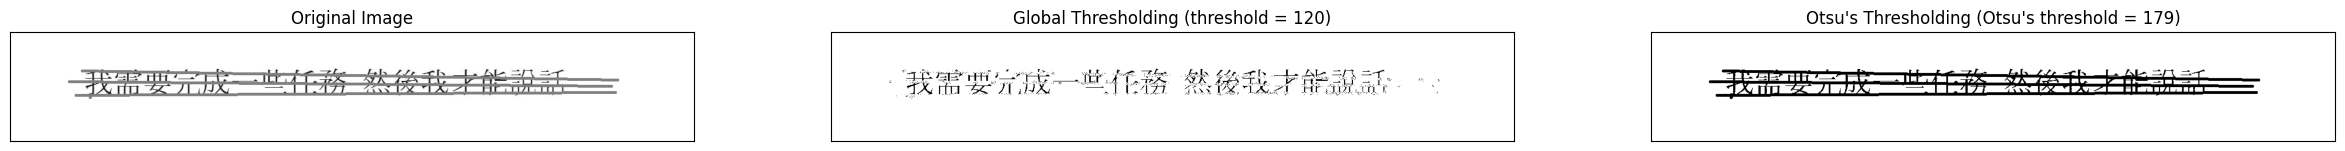

In [78]:
threshold = 120
ret1, thresh1 = cv.threshold(image, threshold, 255, cv.THRESH_BINARY)
ret2, thresh2 = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
titles = ['Original Image', 'Global Thresholding (threshold = %d)' % threshold,
          "Otsu's Thresholding (Otsu's threshold = %d)" % ret2]
images = [image, thresh1, thresh2]

plt.figure(figsize=(30, 8))
for i in np.arange(len(images)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### 1.3 Адаптивная бинаризация.

В простой полутоновой бинаризации в качестве порога используется одно значение. Но это может быть не во всех случаях, например, если изображение имеет разные условия освещения в разных областях. В этом случае может помочь адаптивное пороговое значение. Здесь алгоритм определяет порог для пикселя на основе небольшой области вокруг него. Таким образом, мы получаем разные пороги для разных областей одного и того же изображения, что дает лучшие результаты для изображений с различной освещенностью.

Помимо описанных выше параметров, метод `cv.adaptiveThreshold()` принимает три входных параметра:

- **AdaptiveMethod** решает, как вычисляется пороговое значение:
    + `cv.ADAPTIVE_THRESH_MEAN_C`: Пороговое значение представляет собой среднее значение площади окрестностей минус константа C.
    + `cv.ADAPTIVE_THRESH_GAUSSIAN_C`: Пороговое значение представляет собой гауссово-взвешенную сумму значений окрестностей минус константа C.
- **BlockSize** определяет размер области соседства, а C — константа, которая вычитается из средней или взвешенной суммы соседних пикселей.

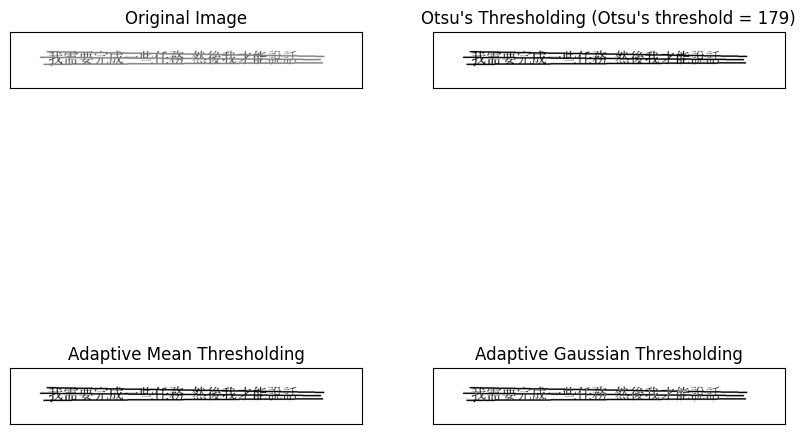

In [19]:
ret1, thresh1 = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
thresh2 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, 5)
thresh3 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 5)
titles = ['Original Image', "Otsu's Thresholding (Otsu's threshold = %d)" % ret1,
          'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [image, thresh1, thresh2, thresh3]

plt.figure(figsize=(10, 8))
for i in np.arange(len(images)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

### 1.4 Сегментация многомодальных изображений (Мультипороговая гистограммная бинаризация)

<img src="../content/multimodal_segmentation.png" width="800"/>

Сегментация многомодальных изображений - специально разработанный для данного класса задач, метод статистического выделения мод позволяет оценивать количество и степень выраженности мод гистограммы, опираясь на соответствующий график статистической производной (функции локальной разделимости), представляющий собой график значений критерия Оцу, вычисляемых в локальном скользящем окне, согласованном по ширине с ожидаемой шириной моды гистограммы.



### 1.5 Цветовая сегментация изображений

Известно, что цветные цифровые изображения представляют собой совокупность трех цветовых плоскостей, каждая из которых характеризует одну независимую составляющую цвета, представленную в том же формате, что и обычное 8-битное полутоновое изображение. Следовательно, все описанные процедуры обработки полутоновых изображений в яркостной области могут быть обобщены и на случай обработки цветных изображений. Специфика же здесь связана прежде всего с различными цветовыми моделями, позволяющими по-разному работать с разными цветовыми и другими составляющими изображения.


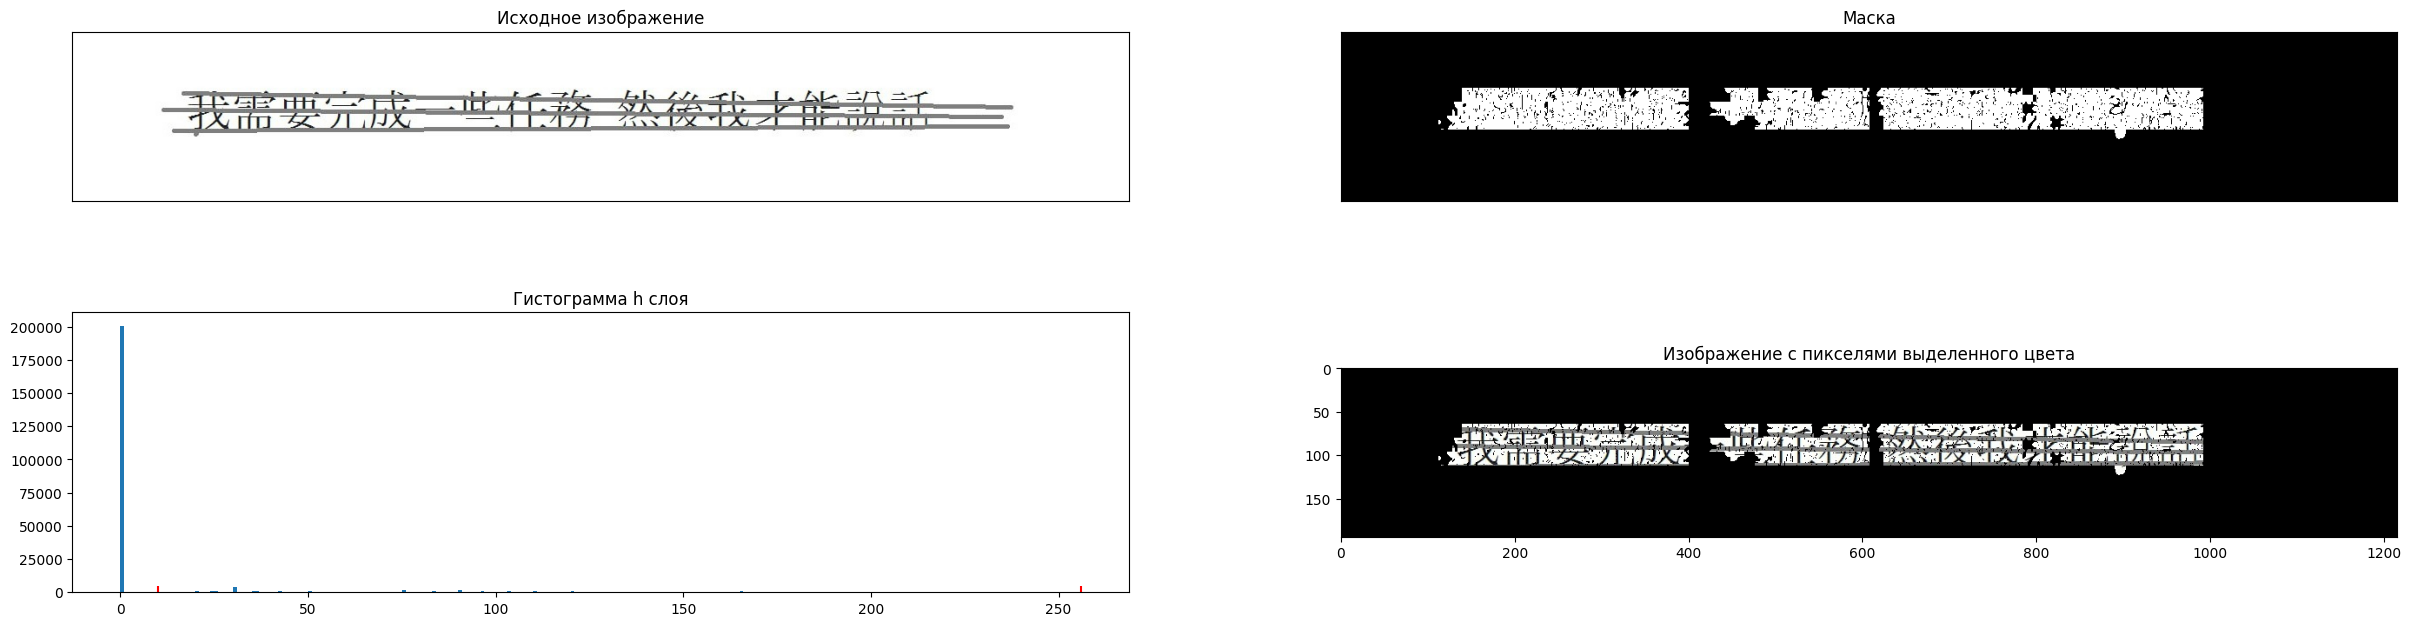

In [74]:
image3 = cv.imread('../images/lab4.png')
rgb_image3 = cv.cvtColor(image3, cv.COLOR_BGR2RGB)
hsv_image3 = cv.cvtColor(rgb_image3, cv.COLOR_RGB2HSV)
h, s, v = cv.split(hsv_image3)

low_h = 10
high_h = 256

mask = cv.inRange(h, low_h, high_h)
result = cv.bitwise_and(rgb_image3, rgb_image3, mask=mask)

gs = plt.GridSpec(2, 2)
plt.figure(figsize=(30, 8))
plt.subplot(gs[0])
plt.imshow(rgb_image3)
plt.title('Исходное изображение')
plt.xticks([]), plt.yticks([])
plt.subplot(gs[1])
plt.imshow(mask, cmap='gray')
plt.title('Маска')
plt.xticks([]), plt.yticks([])
plt.subplot(gs[2])
plt.hist(h.reshape(-1), np.max(h), [np.min(h), np.max(h)])
plt.vlines(low_h, 0, 5000, 'r'), plt.vlines(high_h, 0, 5000, 'r')
plt.title('Гистограмма h слоя')
plt.subplot(gs[3])
plt.imshow(result)
plt.title('Изображение с пикселями выделенного цвета')
plt.show()

# 2 Выделение границ.

Традиционно, рассматриваются две модели краев: "ступенька" и "излом". Точкам контура типа "ступенька" соответствуют точки смены знака второй производной, а точкам контура типа "излом" - точки смены знака первой производной изображения. Здесь делается допущение, что изображение это непрерывная и два раза дифференцируемая функция f(x,y). В действительности это допущение будет корректным, если перед взятием производной - изображение сгладить (отфильтровать) тем или иным способом.

Из методов обнаружения края при помощи различных дифференциальных операторов наиболее известны операторы Робертса (Roberts), Собеля (Sobel), Канни (Canny), оператор Лапласа и Лапласиан Гаусcиана (LoG).

## 2.1 Операторы вычисления векторов градиентов

Операторы Робертса и Собеля реализуются путем свертки изображения со следующими ядрами:

- Оператор Робертса:
$
M_1 =
 \begin{pmatrix}
  1 & 0 \\
  0 & -1
 \end{pmatrix}
;
M_2 =
 \begin{pmatrix}
  0 & -1\\
  1 & 0
 \end{pmatrix}
.
$

- Оператор Собеля:
$
M_x =
\begin{pmatrix}
 1 & 0 & -1 \\
 2 & 0 & -2 \\
 1 & 0 & -1
 \end{pmatrix}
;
M_y =
\begin{pmatrix}
 1  & 2  & 1 \\
 0  & 0  & 0 \\
 -1 & -2 & -1
 \end{pmatrix}
.
$

Исследования показали, что оператор Робертса не является в достаточной мере помехозащищенным. Оператор Собеля обеспечивает вполне удовлетворительные результаты при обработке реальных изображений.
В каждой точке изображения приближённое значение величины градиента можно вычислить путём использования полученных приближенных значений производных:
$ G = \sqrt{G^2_x + G^2_y} $,
где $ G_x = M_x * Image $, а  $ G_y = M_y * Image $
Символ $*$ здесь - это операция свертки.
Используя эту информацию, мы можем также вычислить направление градиента:
${\displaystyle \mathbf {\Theta } =\operatorname {arctan} \left({\mathbf {G} _{y} \over \mathbf {G} _{x}}\right)} $,
где, к примеру, угол Θ равен нулю для вертикальной границы, у которой тёмная сторона слева.


In [9]:
image1 = cv.imread('../images/lab4.png')
gray_image1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
rgb_image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)

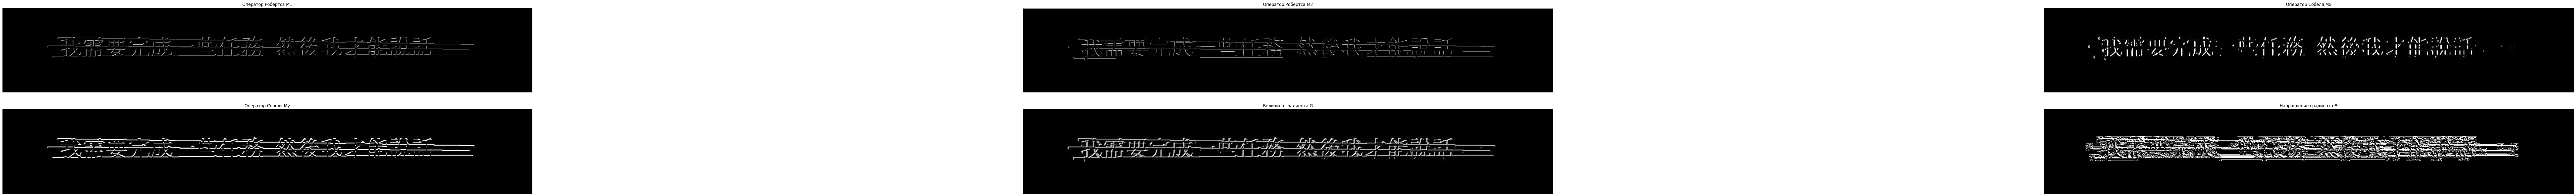

In [75]:
M1 = np.asarray([[1, 0], [0, -1]])
M2 = np.asarray([[0, -1], [1, 0]])
Mx = np.asarray([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
My = np.asarray([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

kernels = [M1, M2, Mx, My]

gs = plt.GridSpec(3, 3)
plt.figure(figsize=(150, 15))

titles = ['Оператор Робертcа M1', 'Оператор Робертcа M2', 'Оператор Собеля Mх',
          'Оператор Собеля My', 'Величина градиента G', 'Направление градиента Θ']
numberOfImage = 6
shape = gray_image1.shape
filtered_images = np.empty(shape[0] * shape[1] * numberOfImage).reshape(shape[0], shape[1], numberOfImage)

for i in np.arange(numberOfImage - 2):
    filtered_images[..., i] = cv.filter2D(gray_image1, -1, kernels[i])

filtered_images[..., 4] = np.sqrt(filtered_images[..., 2] ** 2 + filtered_images[..., 3] ** 2)
filtered_images[..., 5] = np.arctan2(filtered_images[..., 3], filtered_images[..., 2])

for i in np.arange(numberOfImage):
    plt.subplot(gs[i])
    plt.xticks([]), plt.yticks([])
    plt.title(titles[i])
    plt.imshow(filtered_images[..., i], cmap='gray')

plt.show()

## 2.2 Операторы Лапласа и Лапласиан Гауссиана
Рассмотрим операторы выделения краев на, основанных на вычислении производных.

Простейшим оператором такого рода является оператор Лапласа.

**оператор Лапласа** (Лапласиан) - это дифференциальный оператор, который является обобщением на функции нескольких переменных второй производной функции одной переменной. Обозначается символом $\Delta$. Оператор Лапласа примененный к некоторой функции F ставит в соответствие функцию:
$\Delta F = \frac{\partial^2 F}{\partial x^2_1} + \frac{\partial^2 F}{\partial x^2_2} + \dots + \frac{\partial^2 F}{\partial x^2_n}$ для n-мерного пространства. В случае пространственной обработки изображений чаще всего $n=2$.

Ядро лапласиана размером 3x3 выглядит так:
$$
 \begin{pmatrix}
  -1 & -1 & -1 \\
  -1 & 8 & -1 \\
  -1 & -1 & -1
 \end{pmatrix}
$$
Эта маска позволяет в равной степени учитывать возможные перепады яркости во всех направлениях.

**Лапласиан Гауссиана (LoG)** - это оператор выделения краев ступенчатого типа основанный на использовании оператора Лапласа, примененного после сглаживания изображения гауссовским линейным фильтром или непосредственно осуществляется свертка с маской $\Delta G(\sigma,x,y)$. Этот фильтр также известен как *разность гауссовских распределений* (difference of Gaussians ,DoG), т.к. форма маски $\Delta G(\sigma,x,y)$ хорошо аппроксимируется разностью гауссовских масок $G(\sigma_1) - G(\sigma_2)$ с соотношением $\frac{\sigma_1}{\sigma_2} = 1.7$.

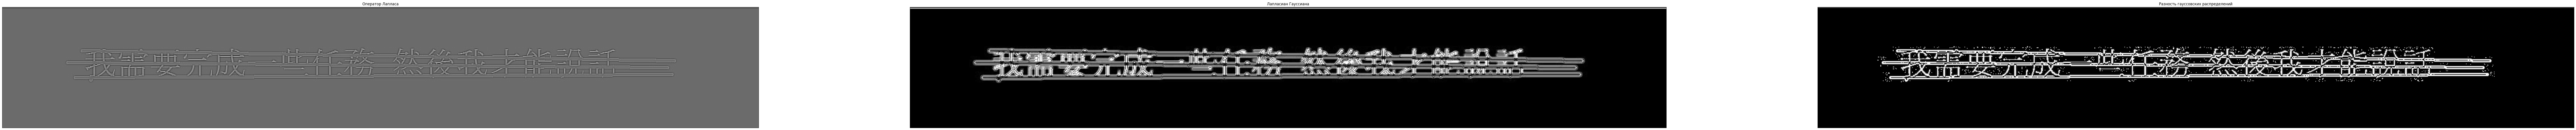

In [76]:
outImageDepth = cv.CV_16S  # глубина результирующего изображения. Т.к. входное изображение 8-битное, чтобы избежать переполнения сделаем выходное изображение 16-битное.

gaussian33 = cv.GaussianBlur(gray_image1, (3, 3), 0)
gaussian55 = cv.GaussianBlur(gray_image1, (5, 5), 0)

# применяем оператор Лапласа к тестовому изображению
laplace = cv.Laplacian(gray_image1, outImageDepth, ksize=3)
# laplace = cv.convertScaleAbs(laplace)
# вычисляем разность гауссовских разпределений
dog = gaussian33 - gaussian55
# dog = cv.convertScaleAbs(dog)
# вычисляем Лапласиан Гауссиана
log = cv.Laplacian(gaussian33, outImageDepth, ksize=3)
log = cv.convertScaleAbs(log)

# вывод
plt.figure(figsize=(150, 8))
gs = plt.GridSpec(1, 3)

titles = ['Оператор Лапласа', 'Лапласиан Гауссиана', 'Разность гауссовских раcпределений']
outImages = [laplace, log, dog]

for i in np.arange(len(outImages)):
    plt.subplot(gs[i])
    plt.xticks([]), plt.yticks([])
    plt.title(titles[i])
    plt.imshow(outImages[i], cmap='gray')

plt.show()

## 2.3 Оператор Канни
Оператор Канни использует многоступенчатый алгоритм для обнаружения границ в изображениях.
Алгоритм Канни состоит из следующих шагов:
- сглаживание изображения;
- вычисление градиента. Используются четыре фильтра для обнаружения горизонтальных, вертикальных и диагональных ребер в размытом изображении;
- подавление немаксимумов. Только локальные максимумы отмечаются как границы;
- двойная пороговая фильтрация. Потенциальные границы определяются порогами;
- трассировка области неоднозначности. Итоговые границы определяются путём подавления всех краёв, не связанных с определенными (сильными) границами.

К счастью, нам не нужно реализовывать алгоритм Канни, т.к. его реализация есть в OpenCV.
Алгоритм Канни реализован в OpenCV в функции Canny. Для его настройки его работы нужно передать функции два порога.
Подробнее про алгоритм Канни можно почитать в [документации](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html)

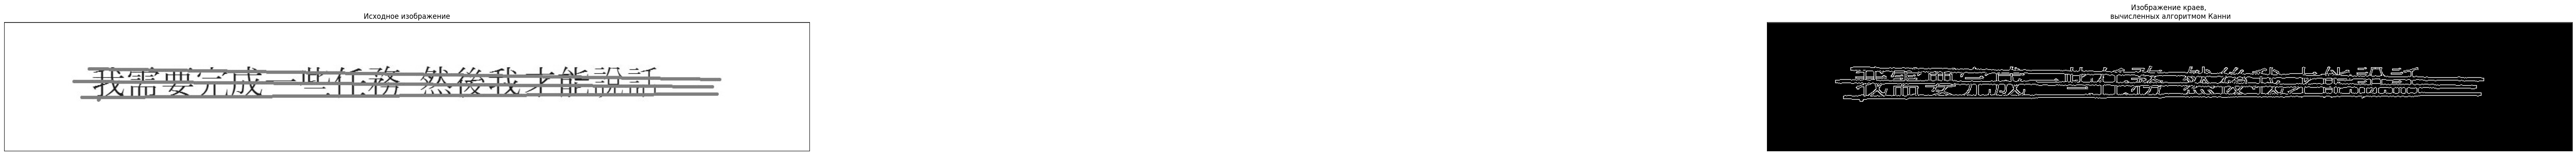

In [77]:
threshold1 = 100
threshold2 = 200
edges = cv.Canny(gray_image1, threshold1, threshold2)

# вывод
plt.figure(figsize=(100, 4))
plt.subplot(121), plt.imshow(gray_image1, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Изображение краев, \n вычисленных алгоритмом Канни'), plt.xticks([]), plt.yticks([])
plt.show()

# 3 Методы анализа изображений

## 3.1 Математическая морфология Серра

Математическая морфология Серра позволяет осуществлять обработку изображений с учетом формы и размера имеющихся на изображении областей. Морфологические операторы Серра позволяют: выделять или удалять на изображениях мелко- и среднеразмерные объекты заданной формы и размера, а также фильтровать (сглаживать) форму крупноразмерных объектов.

Базовыми операциями математической морфологии Серра являются: дилатация (расширение) и эрозия (сжатие) изображения X структурирующим элементом B. На этих базовых операциях основаны также операции открытия и закрытия.

Рассмотрим геометрический смысл операторов математической морфологии на примере обработки искусственного изображения.

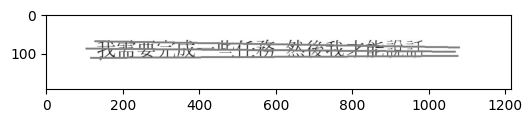

In [13]:
image = cv.imread('../images/lab4.png')
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
noise_image = util.add_salt_and_peper_noise(image, 0.02)
plt.imshow(image, 'gray')

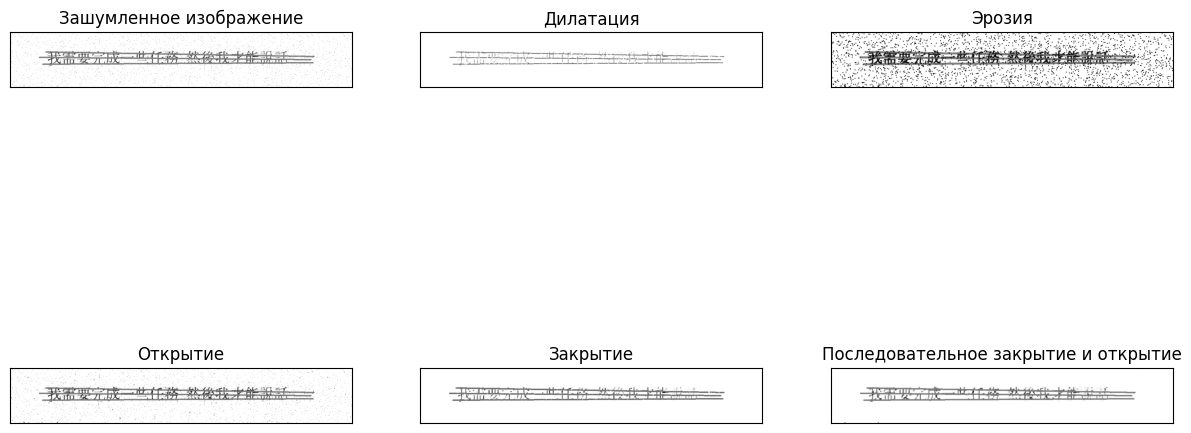

In [14]:
kernel = np.ones((3, 3), np.uint8)
dilation = cv.dilate(noise_image, kernel, iterations=1)
erosion = cv.erode(noise_image, kernel, iterations=1)
opening = cv.morphologyEx(noise_image, cv.MORPH_OPEN, kernel)
closing = cv.morphologyEx(noise_image, cv.MORPH_CLOSE, kernel)
closeAndOpen = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel)

# вывод
plt.figure(figsize=(15, 8))
gs = plt.GridSpec(2, 3)

titles = ['Зашумленное изображение', 'Дилатация', 'Эрозия', 'Открытие', 'Закрытие',
          'Последовательное закрытие и открытие']
outImages = [noise_image, dilation, erosion, opening, closing, closeAndOpen]

for i in np.arange(len(outImages)):
    plt.subplot(gs[i])
    plt.xticks([]), plt.yticks([])
    plt.title(titles[i])
    plt.imshow(outImages[i], cmap='gray')

plt.show()

## 3.2 Сопоставление шаблонов

Сопоставление шаблонов — это метод поиска фрагмента изображения (шаблона) и его местоположения в более крупном изображении. Работа метода основана на перемещении окна (ROI) по входному изображению (как в свертке) и вычислении метрики близости фрагмента изображения, ограниченного окном с шаблоном. Результатом этой работы является новое изображение, где каждый пиксель имеет значение метрики близости фрагмента изображения в текущей окрестности с шаблоном. В OpenCV для этого используется функция cv.matchTemplate().
Когда есть выходное изображение с мерой близости можно использовать функцию cv.minMaxLoc() чтобы найти координаты пикселя с максимальным (минимальным) значением меры близости.
В OpenCV реализовано несколько методов [сравнения](https://docs.opencv.org/3.4/df/dfb/group__imgproc__object.html#ga3a7850640f1fe1f58fe91a2d7583695d). От этого зависит максимальное или минимальное значение необходимо искать.


In [15]:
bgr_image = cv.imread('../images/lab4.png')
gray_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2GRAY)

ROI = (220, 210, 135, 180)  #(x0, y0, height, width)
template = gray_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]

w, h = template.shape[::-1]
# Список всех 6 методов для сравнения
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
           'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    method = eval(meth)

    res = cv.matchTemplate(gray_image, template, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # Для методов TM_SQDIFF и TM_SQDIFF_NORMED берется минимум, для остальных максумум res
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(gray_image, top_left, bottom_right, 255, 2)
    plt.subplot(121), plt.imshow(res, cmap='gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(gray_image, cmap='gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\templmatch.cpp:588: error: (-215:Assertion failed) corr.rows <= img.rows + templ.rows - 1 && corr.cols <= img.cols + templ.cols - 1 in function 'cv::crossCorr'


In [ ]:
bgr_image = cv.imread('../images/lab4.png')
rgb_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(rgb_image)


# 4. Локальные особенности. Особые точки.

Локальные особенности изображения - это хорошо различимые фрагменты объектов на изображении. Как правило, речь идет о поиске точек, каждая из которых обладает характерной окрестностью, отличающую эту точку от остальных.
 В разной литературе точки с локальными особенностями называют особыми точками (feature points или просто features), локальными особыми точками (local feature points) или характеристическими точками (characteristic points).

При поиске особых точек, к ним предъявляются следующие требования:
- повторимость, т.е. находились всегда в том же месте несмотря на изменения масшаба, положения, ракурса и освещения;
- локальность. Особые точки должны определяться маленькой окрестностью, чтобы работа с ней не была чувствительна к перекрытиям;
- значимость. Каждая точька должна иметь уникальное описание;
- компактность и эффективность. Количество особых точек, должно быть значительно меньше пикселей изображения.

Особые точки используются в задачах поиска и выделения объектов на изображениях, распознавания объектов на изображениях, для поиска изображений в базе данных или в файловой системе, сопоставления изображений, например, для построения карты местности.

Алгоритмы поиска особых точек называются детекторами. Рассмотрим некоторые из них.

## 4.1 Детектор Харриса

Детектор Харриса - один из первых и самых популярных детекторов особых точек. Ищет такие точки, окрестность которых меняется при любом сдвиге. При создании этого детектора авторами (Крисом Харрисом и Майком Стивенсом) было предложено в качестве особых точек искать углы. и  Такими точками в Харрис и  предлагаются искать углы.

Подробное описание алгоритма и пример его работы можно посмотреть на сайте [OpenCV](https://docs.opencv.org/4.5.5/dc/d0d/tutorial_py_features_harris.html)



In [ ]:
rgb_image = cv.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)

cropped_image = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv.cvtColor(cropped_image, cv.COLOR_BGR2GRAY)

gray_image = np.float32(gray_image)
dst = cv.cornerHarris(gray_image, 2, 3, 0.04)
# Threshold for an optimal value, it may vary depending on the image.
cropped_image[dst > 0.01 * dst.max()] = [255, 0, 0]
plt.imshow(cropped_image)

Если стоит задача поиска углов с субпиксельной точностью, можно использовать функцию cv.cornerSubPix(), которая дополнительно уточняет обнаруженные углы с точностью до субпикселя.

In [ ]:
rgb_image = cv.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
image = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# find Harris corners
gray_image = np.float32(gray_image)
dst = cv.cornerHarris(gray_image, 2, 3, 0.04)
dst = cv.dilate(dst, None)
ret, dst = cv.threshold(dst, 0.01 * dst.max(), 255, 0)
dst = np.uint8(dst)
# find centroids
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)
# define the criteria to stop and refine the corners
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv.cornerSubPix(gray_image, np.float32(centroids), (5, 5), (-1, -1), criteria)
# Now draw them
res = np.hstack((centroids, corners))
res = np.int0(res)
image[res[:, 1], res[:, 0]] = [0, 0, 255]
image[res[:, 3], res[:, 2]] = [0, 255, 0]
plt.imshow(image)

Чтобы увидеть результат, нужно приблизить получившееся изображение. Должно получиться как на рисунке:
<img height="100" src="../content/subpixel_corner_detection.png"/>

## 4.2 Детектор Shi-Tomasi
Детектор Shi-Tomasi является усовершенствованным вариантом детектора Харриса.
Для нахождения особых точек методом Shi-Tomasi в OpenCV есть функция goodFeaturesToTrack(). Она находит N сильнейших углов на изображении. В качестве параметров функции передается: желаемое число углов, которое нужно найти; число от 0 до 1, определяющее уровень "качества" углов, ниже которого найденые углы отсекаются; минимальное евклидово расстояние между найденными углами.
Подробнее про функцию [goodFeaturesToTrack()](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)

In [ ]:
rgb_image = cv.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
image = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

corners = cv.goodFeaturesToTrack(gray_image, 54, 0.01, 10)
corners = np.int0(corners)
for i in corners:
    x, y = i.ravel()
    cv.circle(image, (x, y), 3, 255, -1)

plt.imshow(image), plt.show()

##  4.3 SIFT (Scale-Invariant Feature Transform)

SIFT -- это детектор инвариантный (нечувствительный) к масштабированию. Как известно, рассмотренные выше детекторы особых точек инвариантны к повороту изображения благодаря тому, что они обнаруживают углы. Но углы в одном масштабе могут не являться углами в другом масштабе.
<img height="100" src="../content/corners_example.png"/>
В отличии от детектора Харриса, SIFT является инвариантным к масштабированию. А в качестве особых точек ищет не углы, а иные точки изображения инвариантные к повороту, смещению, масштабированию, изменению освещенности и частично к аффинным преобразованиям.
Подробнее в статье на сайте [OpenCV](https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html).

Рассмотрим применение SIFT с использованием OpenCV.


In [ ]:
rgb_image = cv.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
image = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

sift = cv.SIFT_create()
kp = sift.detect(gray_image, None)
image = cv.drawKeypoints(gray_image, kp, image, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(image)

## 4.4 FAST
Рассмотренные выше алгоритмы поиска особых точек на изображениях достаточно эффективны, но вычислительно сложные. Они не позволяют использовать их в приложениях реального времени на устройствах с ограниченными вычислительными ресурсами.

Для решения этой проблемы был предложен алгоритм [FAST](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html).

Применение детектора FAST с использованием OpenCV представлен ниже.

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

rgb_image = cv.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
img = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Initiate FAST object with default values
fast = cv.FastFeatureDetector_create()
# find and draw the keypoints
kp = fast.detect(img,None)
img2 = cv.drawKeypoints(img, kp, None, color=(255,0,0))
# Print all default params
print( "Threshold: {}".format(fast.getThreshold()) )
print( "nonmaxSuppression:{}".format(fast.getNonmaxSuppression()) )
print( "neighborhood: {}".format(fast.getType()) )
print( "Total Keypoints with nonmaxSuppression: {}".format(len(kp)) )
cv.imwrite('fast_true.png', img2)
plt.imshow(img2)

## 4.5 ORB (Oriented FAST and Rotated BRIEF)

[ORB](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html) - это быстрый и надежный детектор особых точек, представленный в 2011 году. Он основан на детекторе FAST и модифицированном детектора BRIEF. Целью его создания было предоставление бесплатного детектора для замены запатентованного детектора SIFT, использование которого в коммерческих целях требовало лицензионных отчислений автору.

In [20]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

rgb_image = cv.imread('../images/calibration/left01.jpg')
ROI = (235, 75, 290, 200)  #(x0, y0, height, width)
img = rgb_image[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img,None)
# compute the descriptors with ORB
kp, des = orb.compute(img, kp)
# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

error: OpenCV(4.8.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0xa7e5ea26::Set<1,-1,-1>,struct cv::impl::A0xa7e5ea26::Set<0,2,5>,3>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1
